In [1]:
%load_ext autoreload
%autoreload 2

from pykeops_utils import *
from torch import tensor

plt.rcParams.update({'font.size': 20})

import sys
sys.path.insert(1,'../data/')
from datasets import Deterministic_lotka_volterra

sys.path.insert(1,'../')
from visualization import hist_matrix
import scipy.io as sio


import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import cm


True
<class 'torch.cuda.FloatTensor'>
<class 'torch.cuda.LongTensor'>


In [2]:
dtype_ex = torch.double
device_ex = 'cuda'

##########################################################
##########################################################
total_sample_size = 100000
data_available = True
target = Deterministic_lotka_volterra(T=20)
dim_x  = target.d
dim_y  = 18

# define samples
if data_available == False:
    model_data = target.sample_joint(N=total_sample_size)
    torch.save(model_data, './samples.pt')
else:
    # load data
    model_data = torch.load('./samples.pt')

# check moments of data
print(torch.mean(model_data))
print(torch.std(model_data))

# discard outliers
non_outlier_target_idx = torch.where(torch.sum(torch.abs(model_data),axis=1) < 1e4)[0]
model_data = model_data[non_outlier_target_idx,:]

# check moments of data
print(torch.mean(model_data))
print(torch.std(model_data))

# print sizes
print(model_data.shape)

# normalize data
data_mean = torch.mean(model_data,axis=0)
data_std  = torch.std(model_data,axis=0)
model_data = (model_data - data_mean[None,:])/data_std[None,:]

# split into x and y
model_x, model_y = model_data[:,:dim_x], model_data[:,dim_x:]
target_data = torch.hstack((model_y, model_x))
target_data = target_data.to(dtype=dtype_ex,device=device_ex)
source_data = torch.hstack((model_y, torch.randn(model_y.shape[0], dim_x)))
source_data = source_data.to(dtype=dtype_ex,device=device_ex)

tensor(1.1269e+15)
tensor(1.6715e+18)
tensor(22.1628)
tensor(52.0394)
torch.Size([99946, 22])


In [3]:
def scale_data(x,beta_vect):
    return x * torch.sqrt(beta_vect)[None,:]

def unscale_map(z,beta_vect):
    return z * torch.sqrt(1./beta_vect)[None,:]

beta = 0.01
beta_vector = torch.ones((dim_x+dim_y),dtype=dtype_ex,device=device_ex)
beta_vector[dim_x:] *= beta
N = len(source_data)

source_data_scaled = scale_data(source_data,beta_vector)
target_data_scaled = scale_data(target_data,beta_vector)
one_over_n = 1/N*torch.ones(source_data.shape[0],dtype=dtype_ex,device=device_ex)

eps=0.01
_,geps = T(eps, one_over_n, source_data_scaled, one_over_n, target_data_scaled, Nits_max=None,keops_available = keops_available)


In [4]:
class pykeops_drift_test():
    def __init__(self,data,pot,eps):
        self.data = data.to('cuda')
        self.pot = pot.to('cuda')
        self.eps = eps

    def estimator(self,x,t):
        M = squared_distances(torch.transpose(x,0,1),self.data)/(t)
        K = -M/self.eps + self.pot/self.eps
        gammaz = -torch.max(K,dim=1)[0]
        K +=  gammaz.view(-1,1) ### does this operation in-place
        torch.exp(K,out=K) ### does this operation in-place
        top_ = torch.matmul(K,self.data)
        bot_ = K.sum(axis=1,keepdim=False)
        entmap = torch.transpose(top_,0,1)/bot_
        return (-x + entmap)/(t)
    
    def __call__(self,x,t):
        return self.estimator(x,t)
    
    
class ent_map():
    def __init__(self,data,pot,eps):
        self.data = data
        self.pot = pot
        self.eps = eps
        
    def __call__(self,x):
        M = squared_distances(x,self.data)
        K = -M/self.eps + self.pot/self.eps
        gammaz = -torch.max(K,dim=1)[0]
        K +=  gammaz.view(-1,1) ### does this operation in-place
        torch.exp(K,out=K) ### does this operation in-place
        top_ = torch.matmul(K,self.data)
        bot_ = K.sum(axis=1,keepdim=False)
        entmap = top_.T/bot_
        return entmap


In [5]:
nsamples = 50000
# load data
data = sio.loadmat('problem_data.mat')
yobs = (data['yobs'] - data_mean[dim_x:].numpy())/data_std[dim_x:].numpy()
xtrue = data['xtrue'][0,:]

# generate samples
x1 = torch.tensor(np.tile(yobs.T, nsamples).T)
rho2_given_1 = torch.randn((nsamples, dim_x))
joint_samples = torch.hstack((x1,rho2_given_1))

In [6]:
#drift_fn = pykeops_drift_test(target_data_scaled,geps,eps)
entropic_map = ent_map(target_data_scaled.to('cpu'),geps.to('cpu'),eps)


In [7]:
one_step = unscale_map( entropic_map( scale_data(joint_samples,beta_vector.to('cpu'))).T,beta_vector.to('cpu'))


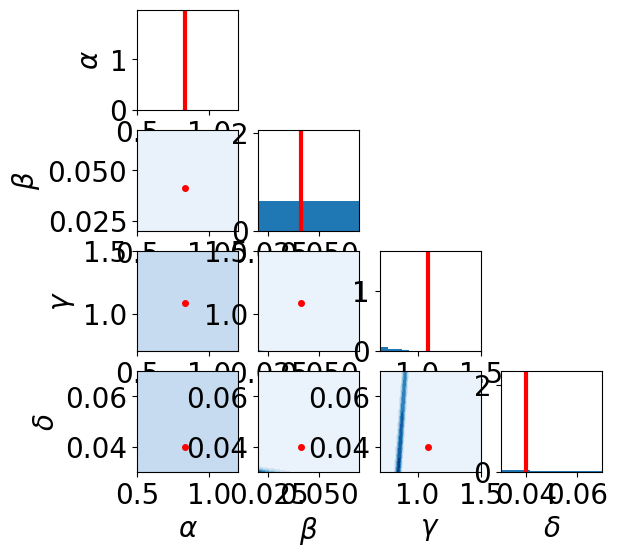

In [8]:
symbols = [r'$\alpha$',r'$\beta$',r'$\gamma$',r'$\delta$']
limits = [[0.5,1.2],[0.02,0.07],[0.7,1.5],[0.03,0.07]]

# plot samples
one_step_samples = one_step[:,dim_y:]
hist_matrix(one_step_samples, symbols, limits, xtrue)
